# Lab Session #5
## Computational Neurophysiology [E010620A]
### Dept of Electronics and Informatics (VUB) and Dept of Information Technology (UGent)
Jorne Laton, Lloyd Plumart, Talis Vertriest, Jeroen Van Schependom, Sarah Verhulst

<font color=blue>Student names and IDs:</font> Robbe De Beck [01902805], Robbe De Muynck [01908861]
<br>
<font color=blue>Academic Year:</font> 2022-2023

# Module 3: Brunel network

In this practical, you will simulate a network of sparsely connected identical Leaky-Integrate-and-Fire neurons. 

This model is based on the paper by [Brunel 2000](https://link.springer.com/article/10.1023/A:1008925309027) and is also discussed in [Neuronal Dynamics](http://neuronaldynamics.epfl.ch), see eg. Figure 13.7. 

We will show that a large network of neurons consisting of a group of excitatory and a group of inhibitory neurons that receive external input is capable of producing a rich dynamics. The parameters that we will vary to trigger different states are (1) the driving frequency of the external population and (2) the relative strength of inhibition vs excitation (g). 

To do so, we will follow two strategies both relying on the BRIAN package: the first strategy is to create our own network from scratch. This will allow you to get acquainted with the BRIAN package and will prepare you for the second strategy. Here, you will use a pre-defined spiking network (included in the BRIAN package), but you will have to make sure you understand its input and outputs in order to induce the correct behaviour. 


We start by ensuring all packages are loaded. Make sure to have installed the [Brian Package](https://briansimulator.org/) 

In [36]:
import brian2 as b2
from brian2 import NeuronGroup, Synapses, PoissonInput
from brian2.monitors import StateMonitor, SpikeMonitor, PopulationRateMonitor
from random import sample
from neurodynex3.tools import plot_tools, spike_tools
from numpy import random
import matplotlib.pyplot as plt
import numpy as np

## Step 1.1. Initialising the NeuronGroup instance

We start by defining a NeuronGroup instance. You can find the documentation [here](https://brian2.readthedocs.io/en/2.0rc/reference/brian2.groups.neurongroup.NeuronGroup.html) 

A NeuronGroup instance takes as input the number of neurons, the dynamics of a single neuron 'model', the length of the refractory period and the integration method. Note that initialising the NeuronGroup will not yet run the simulation. Running the simulation will be done in the upcoming blocks once we have added all details to the network. 

The input parameters of the NeuronGroup instance should be: 
- number of neurons: N_Excit (4000) +N_Inhib (1000)
- the model should model the LIF dynamics
- the model should reset at a threshold v = v_reset (10 mV)
- the neurons should have an absolute refractory period (2ms)
- integration method should be linear

What is the default firing threshold? 

In [37]:
# Import neurodynex3 LIF dynamics & check default values
from neurodynex3.brunel_model import LIF_spiking_network
print('default firing threshold:\t', LIF_spiking_network.FIRING_THRESHOLD)
print('default membrane timescale:\t', LIF_spiking_network.MEMBRANE_TIME_SCALE, '\n')

b2.start_scope()

# Define input parameters
N_Excit = 4000
N_Inhib = 1000

v_rest = 0*b2.mV
v_reset = 10*b2.mV
abs_refractory_period = 2*b2.ms

firing_threshold = LIF_spiking_network.FIRING_THRESHOLD
membrane_time_scale = LIF_spiking_network.MEMBRANE_TIME_SCALE
b2.defaultclock.dt = 0.1*b2.ms

lif_dynamics = """
dv/dt = (v_rest - v)/membrane_time_scale : volt
"""
# Initialize NeuronGroup instance
network = NeuronGroup(
    N_Excit+N_Inhib, model=lif_dynamics,
    threshold='v > firing_threshold', refractory=abs_refractory_period,
    method='linear',reset='v = v_reset')

print(network)
print(network.v)

default firing threshold:	 20. mV
default membrane timescale:	 20. ms 

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_2')
<neurongroup_2.v: array([0., 0., 0., ..., 0., 0., 0.]) * volt>


<div class="alert alert-success">
<span style="color:black">

**A1.1 Answer** 

<!-- \begin{tcolorbox}[colback=green!5] -->
    
The default firing threshold is 20 mV.

<!-- \end{tcolorbox} -->
    
</span>

## Step 1.2. Add network structure
Now that we have created a group of neurons, we will define how they are connected. In order to connect neurons to each other, we first need to distinguish the two neuronal populations (the excitatory and inhibitory population). In order to define the first N_Excit neurons to be excitatory and the remaining part to be inhibitory, you can simply use the following code snippet. 

In [38]:
# Define neuron connections: split excitatory & inhibitory population
excitatory_population = network[:N_Excit]
inhibitory_population = network[N_Excit:]

Now, we need to define two types of synapses: excitatory and inhibitory synapses. Allow for a synaptic delay of 1.5*b2.ms and use a random connection probability of 0.1. You can find the documentation [here](https://brian2.readthedocs.io/en/stable/user/synapses.html) 
In order to follow the notations in the book, please use following notation and default values: 

What is the "target" network? 

In [39]:
# Define synapse parameters
w0 = 0.1*b2.mV
g = 4.0
J_excit = w0
J_inhib = -g*w0
synaptic_delay = 1.5*b2.ms
connection_probability = 0.1

# Define excitatory & inhibitory synapses
exc_synapses = Synapses(excitatory_population, target=network, on_pre="v += J_excit", delay=synaptic_delay)
exc_synapses.connect(p=connection_probability)
inhib_synapses = Synapses(inhibitory_population, target=network, on_pre="v += J_inhib", delay=synaptic_delay)
inhib_synapses.connect(p=connection_probability)

<div class="alert alert-success">
<span style="color:black">

**A1.2 Answer** 

<!-- \begin{tcolorbox}[colback=green!5] -->
    
The "target" network is composed of the complete population of excitatory and inhibitory neurons.

<!-- \end{tcolorbox} -->
    
</span>

## Step 1.3. Enter external Poisson input
Next, you can excite the network through an externally applied Poisson input, by using [Poisson Input](https://brian2.readthedocs.io/en/stable/reference/brian2.input.poissoninput.PoissonInput.html). Start with N = 1000 external Poisson neurons at an input rate of 13 Hz with a connectivity strength w = w0. 



In [40]:
# Define PoissonInput parameters
poisson_input_rate = 13*b2.Hz
N_extern = 1000
w_external = w0

# Initialize PoissonInput instance
external_poisson_input = PoissonInput(target=network, target_var="v", N=N_extern,
                                          rate=poisson_input_rate, weight=w_external)


## Step 1.4. Add monitors 
In the final step before running the simulation we will add some monitors that allows us to assess the simulated network once the simulation has finished. In order to do so, we will monitor a random selection of 100 neurons and the use the [PopulationRateMonitor](https://brian2.readthedocs.io/en/2.0rc/reference/brian2.monitors.ratemonitor.PopulationRateMonitor.html), [SpikeMonitor](https://brian2.readthedocs.io/en/2.0rc/reference/brian2.monitors.ratemonitor.PopulationRateMonitor.html) and [StateMonitor](https://brian2.readthedocs.io/en/stable/reference/brian2.monitors.statemonitor.StateMonitor.html). 

Sample 200 of all neurons involved. 

In [41]:
# Define monitors to assess the network simulation
monitored_subset_size = 200
random.seed(123)
idx_monitored_neurons = sample(range(N_Excit + N_Inhib), monitored_subset_size)

# rate_monitor: records instantaneous firing rates, averaged across the neurons of the NeuronGroup.
rate_monitor = PopulationRateMonitor(network)
# spike_monitor: records spikes from the NeuronGroup.
spike_monitor = SpikeMonitor(network, record=idx_monitored_neurons)
# voltage_monitor: records values of the state variable v (voltage) during a simulation
voltage_monitor = StateMonitor(network, "v", record=idx_monitored_neurons)


## Step 1.5. Run the simulation
Run the simulation for a total simulated time of 500 ms using the following line of code. Describe what is plotted. 


In [42]:
# Run simulation for sim_time
sim_time=500.*b2.ms
b2.run(sim_time)

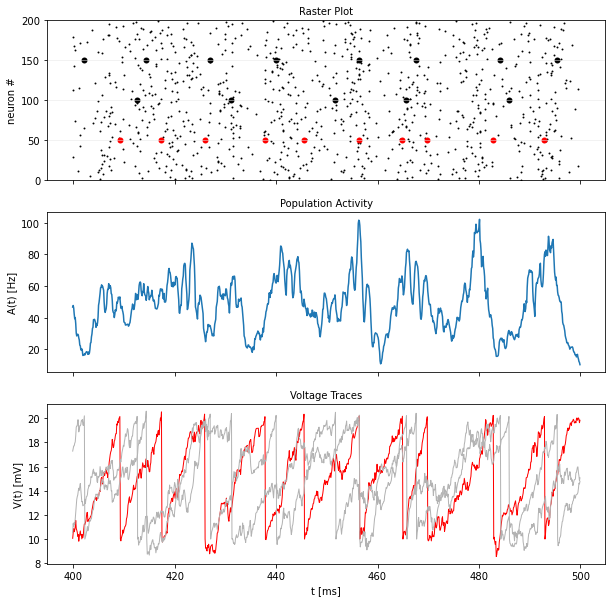

In [43]:
# Plot simulation results
plot_tools.plot_network_activity(rate_monitor, spike_monitor,
                                 voltage_monitor, spike_train_idx_list=idx_monitored_neurons,
                                 figure_size=(10, 10))
plt.show()

Access the data in rate_monitor, spike_monitor, voltage_monitor

First, describe what is described in rate_monitor.rate. Use the smooth_rate function (flat window) to the outputted rates. Make sure to only include the last 150 ms of your simulation. Plot the smoothed_rate in function of time and calculate the mean of the rate across this time window. 

You can the time axis from rate_monitor.t

In [44]:
# Get time axis
ts = rate_monitor.t / b2.ms
t_min, t_max = 350, 500
idx_rate = np.where((t_min <= ts) & (ts < t_max))
print(rate_monitor.rate)

<ratemonitor.rate: array([ 0.,  0.,  0., ...,  4., 30., 30.]) * hertz>


Now, vary the window width across which the rate is averaged and write down your observations (do plot!). 


    Window width: 0.5 ms
    Mean of rate accross time window: 50.07 Hz
    

    Window width: 5.0 ms
    Mean of rate accross time window: 50.01 Hz
    

    Window width: 10.0 ms
    Mean of rate accross time window: 49.83 Hz
    

    Window width: 20.0 ms
    Mean of rate accross time window: 49.08 Hz
    


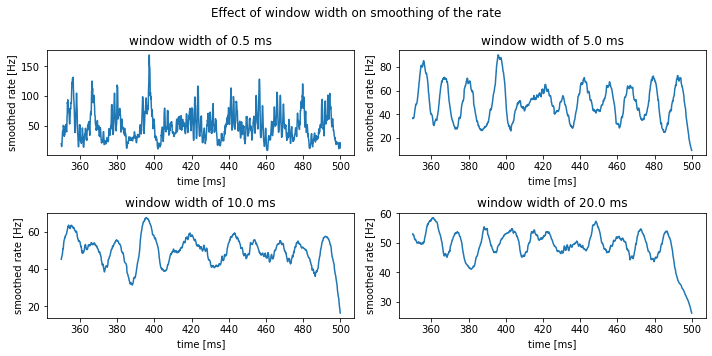

In [45]:
# Investigate the effect window width on smoothing of the rate
window_widths = [0.5, 5, 10, 20]*b2.ms

fig, axs = plt.subplots(2, 2, figsize=(10, 5))
fig.suptitle('Effect of window width on smoothing of the rate')

for i in range(0, 4):
    smoothed_rates = rate_monitor.smooth_rate(window="flat", width=window_widths[i])/b2.Hz
    
    axs[i//2, i%2].plot(ts[idx_rate], smoothed_rates[idx_rate])
    axs[i//2, i%2].set_xlabel('time [ms]')
    axs[i//2, i%2].set_ylabel('smoothed rate [Hz]')
    axs[i//2, i%2].set_title(f'window width of {window_widths[i]*1000} ms')

    print(f"""Window width: {window_widths[i]*1000} ms
Mean of rate accross time window: {np.mean(smoothed_rates[idx_rate]):.2f} Hz
""")

plt.tight_layout()
plt.show()

Now, study what is saved in spike_monitor. Start by creating eventtrains. What is the mean time between two subsequent spikes?  

In [46]:
eventtrains = spike_monitor.event_trains()
# eventtrains is a dictionary mapping neuron indices to spike trains

ISIs = []
for train in eventtrains.values():
    ISI = np.diff(train)
    if len(ISI) > 1:
        ISIs.append(ISI)
mean = np.mean([np.mean(ISI) for ISI in ISIs])
print(f"""Mean time between two subsequent spikes: {mean*1e3:.1f} ms""")

Mean time between two subsequent spikes: 24.8 ms


<div class="alert alert-success">
<span style="color:black">

**A1.5 Answer** 

<!-- \begin{tcolorbox}[colback=green!5] -->
> ***Questions***
Run the simulation for a total simulated time of 500 ms using the following line of code. Describe what is plotted.

The plot constructed with the *plot_network_activity()* method visualizes the results of a network simulation: a dot-raster plot for each monitored neuron that shows its spike-trains, the monitored population activity and the voltage-traces.

    
>First, describe what is described in rate_monitor.rate. Use the smooth_rate function (flat window) to the outputted rates. Make sure to only include the last 150 ms of your simulation. Plot the smoothed_rate in function of time and calculate the mean of the rate across this time window.
You can the time axis from rate_monitor.t

The *rate_monitor.rate* describes the instantaneous firing rates at every timepoint in the simulation, averaged across the neurons of the network.

>Now, vary the window width across which the rate is averaged and write down your observations (do plot!).

!! MAKE OWN ANSWER !!

For a window width of 5 ms the mean rate would be 52 spikes/s. As the window width
increases, the plot becomes smoother/less detailed. In the 0.5 ms window width plot there are still
a lot of (more high frequency) oscillations. These oscillations are not present for windows widths
of 5 ms and greater. The 5 ms and 10 ms window widths seem to capture a similar signal while the
20 ms window width doesn’t capture the signal well. When choosing the window width, there
is a trade-off between losing frequency information (1/window width = min frequency captured)
and getting a better view of the overall trend of a signal (when it is more smooth as with 5 ms).
The overall amplitude decreases for larger window widths (which makes sense of course as high
amplitude values are averaged out).

------------------------
>Now, study what is saved in spike_monitor. Start by creating eventtrains. What is the mean time between two subsequent spikes?  
-------------------------

The *spike_monitor* records the spikes of the monitored neurons. The spikes can be accessed by calling the *spike_trains()* method, which returns a dictionary, mapping neuron indices to spike trains. The mean time between two subsequent spikes is calculated and printed in the code cell above.


<!-- \end{tcolorbox} -->
    
</span>

# 2. The pre-implemented Brunel network

Import the LIF_spiking_network function from neurodynex3.brunel_model and use this function to simulate a network consisting of 10000 excitatory neurons, 2500 inhibitory neurons and 1000 external neurons. 

Further, 
- w0 = 0.1 mV
- total simulated time of 500 ms
- the membrane time scale can be put to default (LIF_spiking_network.MEMBRANE_TIME_SCALE)
- the same goes for the firing threshold (LIF_spiking_network.FIRING_THRESHOLD)
- monitored_subset = 50
- synaptic delay is 1.5ms 

We will vary two parameters: g (an input parameter to simulate_brunel_network) and, second, the firing frequency of the external neurons $\nu_{extern}$. The latter should be expressed as a ratio multiplied with $\nu_{threshold}$. The frequency $\nu_{threshold}$ is the minimal poisson rate in the external neuronal population required to elicit firing in the network in the absence of any feedback. 

According to Brunel (2000), $\nu_{threshold}$ can be calculated as: 

\begin{align}
\nu_{threshold} &= \frac{\theta}{N_{extern}w_0\tau_m}
\end{align}

Does this expression make sense? 

For starters, you can use g=6 and $\nu_{extern} = 4\nu_{threshold}$

Calculate $\nu_{threshold}$ in function of the parameters mentioned above and the corresponding $\nu_{extern}$. And run the simulation. Make sure to output rate_monitor, spike_monitor, voltage_monitor and monitored_spike_idx.

Make sure to start each simulation with a "b2.start_scope()" statement. 

In [70]:
from neurodynex3.brunel_model import LIF_spiking_network
b2.start_scope()

# Default values
FIRING_THRESHOLD = LIF_spiking_network.FIRING_THRESHOLD # 20.*b2.mV
MEMBRANE_TIME_SCALE = LIF_spiking_network.MEMBRANE_TIME_SCALE # 20.*b2.ms


# Set parameters
N_Excit = 10000
N_Inhib = 2500
N_extern = 1000

w0 = 0.1*b2.mV
sim_time = 500*b2.ms
monitored_subset_size = 50
SYNAPTIC_DELAY = 1.5*b2.ms
g = 6

# Determine nu_threshold & nu_extern
nu_threshold = FIRING_THRESHOLD / (N_extern*w0*MEMBRANE_TIME_SCALE)
nu_extern = 4*nu_threshold
print(f"""
nu_threshold =\t{nu_threshold} Hz
nu_extern    =\t{nu_extern} Hz
""")


nu_threshold =	10.0 Hz
nu_extern    =	40.0 Hz



In [71]:
# Run simulation
rate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = \
    LIF_spiking_network.simulate_brunel_network(N_Excit=10000, N_Inhib=2500, N_extern=1000, w0=0.1*b2.mV, sim_time=500*b2.ms,\
                                                 monitored_subset_size=50,g=g,poisson_input_rate=nu_extern)

Plot the output using "plot_network_activity", make sure to add the "t_min" and "t_max" parameter and increase the figure size to figure_size=(10,10). 

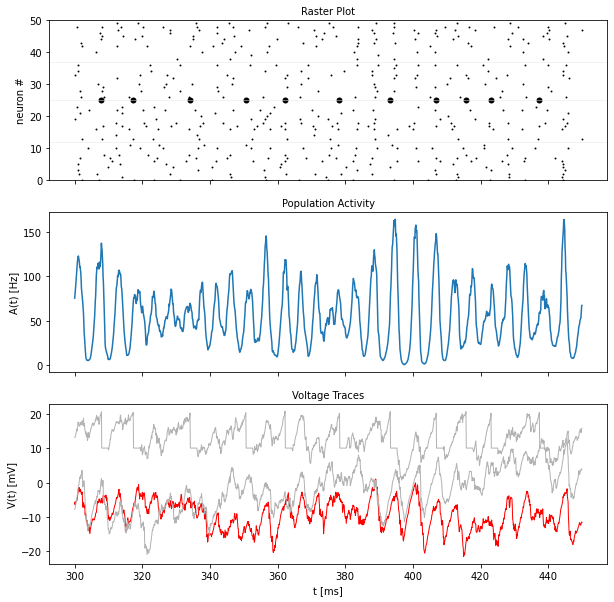

In [72]:
# Plot simulation results
plot_tools.plot_network_activity(rate_monitor, spike_monitor, \
                                 voltage_monitor, spike_train_idx_list=monitored_spike_idx,\
                                 t_min=300*b2.ms, t_max=450*b2.ms,\
                                 figure_size=(10, 10))
plt.show()

The first output to analyse is the rate_monitor. 
Plot - for different choices of window width (0.5, 5, 20) ms - the smoothed_rates and calculate the mean of smoothed_rate across a time window (e.g. between 300 and 450 ms). How does this compare to Table 1 in Brunel (2000)? 


Window width: 0.5 ms
Mean of rate accross time window: 55.38 Hz

Window width: 5.0 ms
Mean of rate accross time window: 55.24 Hz

Window width: 20.0 ms
Mean of rate accross time window: 55.31 Hz



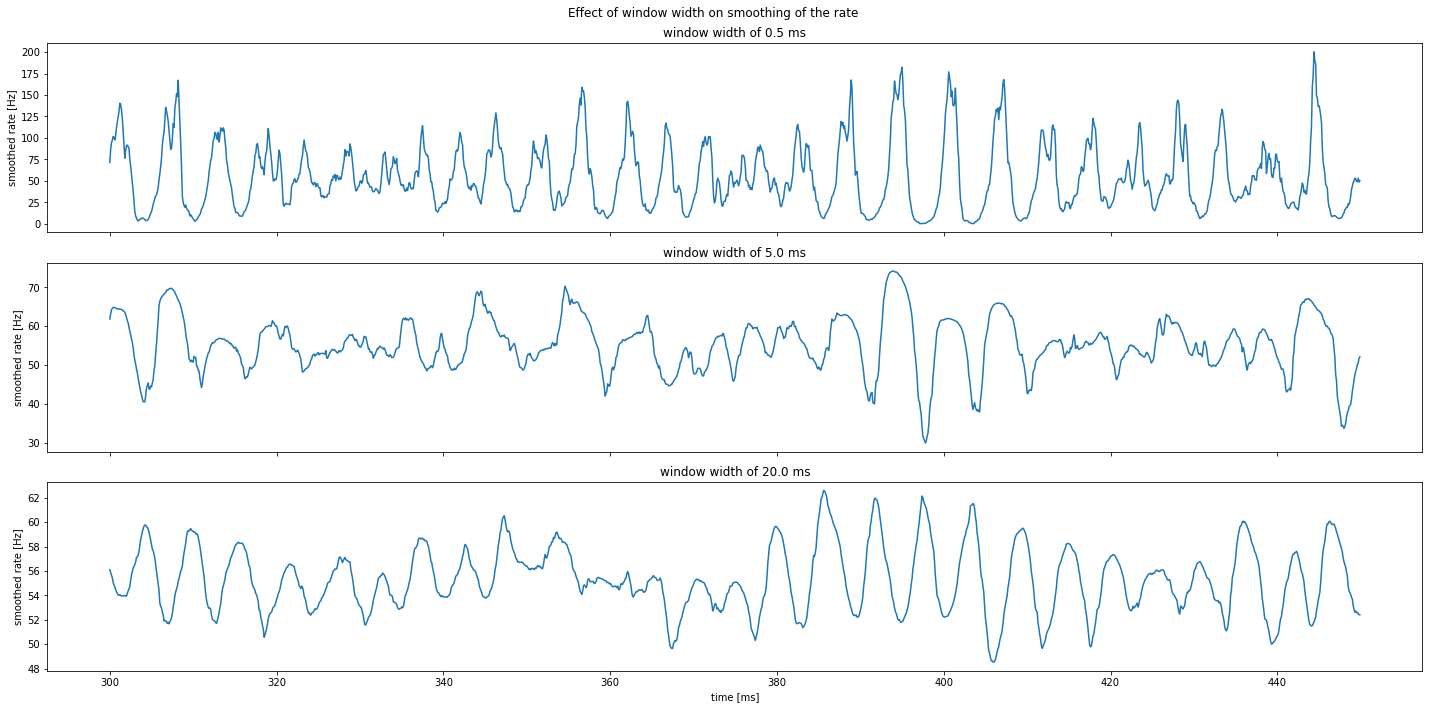

In [73]:
# Get time axis
ts = rate_monitor.t / b2.ms
t_min, t_max = 300, 450
idx_rate = (t_min <= ts) * (ts < t_max)

# Investigate the effect window width on smoothing of the rate
window_widths = [0.5,5,20]*b2.ms

fig, axs = plt.subplots(3, 1, figsize=(20,10), sharex=True)
fig.suptitle('Effect of window width on smoothing of the rate')

for i, window in enumerate(window_widths):
    smoothed_rates = rate_monitor.smooth_rate(window="flat", width=window)/b2.Hz
    
    axs[i].plot(ts[idx_rate], smoothed_rates[idx_rate])
    axs[i].set_ylabel('smoothed rate [Hz]')
    axs[i].set_title(f'window width of {window*1000} ms')

    print(f"""Window width: {window*1000} ms
Mean of rate accross time window: {np.mean(smoothed_rates[idx_rate]):.2f} Hz
""")

axs[-1].set_xlabel('time [ms]')
plt.tight_layout()
plt.show()

Next, we want to assess the global frequency content in rate_monitor. We know that if we have a time signal of 0.5 seconds, the maximal frequency resolution is 2 Hz. Be aware that Welch' method as implemented will chop the data in different pieces (to enable the averaging of the spectrum) yielding a smaller frequency resolution.  

Start by smoothing the rate with a window of 0.5 ms and calculate the spectrum using [signal.welch](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html). What is the sampling frequency fs? 

Plot the spectrum. What is the frequency resolution (look at np.diff(f)[0]). Can you explain how signal.welch arrives at this frequency resolution if you know that it - by default - includes 256 samples and if you check the integration time constant (typically 0.05 ms, but check b2.defaultclock.dt) that you used for the simulation? 

What happens if you impose nperseg = 256*8? 

What happens if you impose nfft = 10000 ? (Answer: you interpolate the spectrum). 

In [74]:
from scipy.signal import welch

10.0
0.0390625
100. us
0.0390625
0.0048828125
0.001


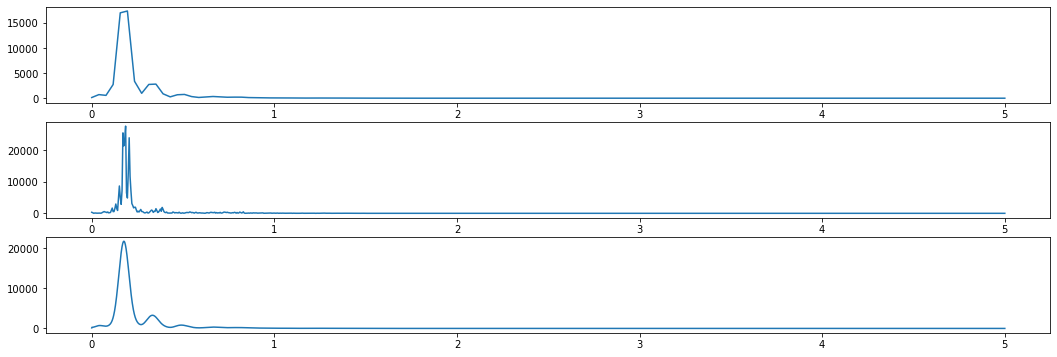

In [75]:
smoothed_rates = rate_monitor.smooth_rate(window="flat", width=0.5*b2.ms)/b2.Hz
Fs = 1/(ts[1]-ts[0])
print(Fs)

freqs, smoothed_rates_spectrum = welch(smoothed_rates, fs=Fs)
freq_res = np.diff(freqs)[0]
print(freq_res)
int_time_cte = b2.defaultclock.dt
print(int_time_cte)
fig, axs = plt.subplots(3,1,figsize=(18,6))

freqs, smoothed_rates_spectrum = welch(smoothed_rates, fs=Fs)
freq_res = np.diff(freqs)[0]
print(freq_res)
axs[0].plot(freqs, smoothed_rates_spectrum)

freqs, smoothed_rates_spectrum = welch(smoothed_rates, fs=Fs, nperseg=256*8)
freq_res = np.diff(freqs)[0]
print(freq_res)
axs[1].plot(freqs, smoothed_rates_spectrum)

freqs, smoothed_rates_spectrum = welch(smoothed_rates, fs=Fs, nfft=10000)
freq_res = np.diff(freqs)[0]
print(freq_res)
axs[2].plot(freqs, smoothed_rates_spectrum)

plt.show()

We will now use the machinery provided by BRIAN to calculate and plot the power spectrum. BRIAN takes a slightly different approach. BRIAN starts from a desired frequency resolution, a desired number of windows over which the spectrum should be averaged and an initial time segment that should be ignored. Based on these desiredata, the minimal simulation length is calculated. 

Example: if we want a frequency resolution of 5 Hz, we need time windows of 200 ms. If we assume non-overlapping time windows and a number of averages the total simulated signal should be k*200ms. 

In this case, we have simulated 0.5 seconds of data. If we aim for an initial segment to be removed of 99ms and a frequency resolution of 10 Hz, what is then the maximal number of windows we can include? 

In [ ]:
def get_population_activity_power_spectrum(
        rate_monitor, delta_f, k_repetitions, T_init=100*b2.ms, subtract_mean_activity=False):
    """
    Computes the power spectrum of the population activity A(t) (=rate_monitor.rate)

    Args:
        rate_monitor (RateMonitor): Brian2 rate monitor. rate_monitor.rate is the signal being
            analysed here. The temporal resolution is read from rate_monitor.clock.dt
        delta_f (Quantity): The desired frequency resolution.
        k_repetitions (int): The data rate_monitor.rate is split into k_repetitions which are FFT'd
            independently and then averaged in frequency domain.
        T_init (Quantity): Rates in the time interval [0, T_init] are removed before doing the
            Fourier transform. Use this parameter to ignore the initial transient signals of the simulation.
        subtract_mean_activity (bool): If true, the mean value of the signal is subtracted. Default is False

    Returns:
        freqs, ps, average_population_rate
    """
    data = rate_monitor.rate/b2.Hz
    delta_t = rate_monitor.clock.dt
    f_max = 1./(2. * delta_t)
    N_signal = int(2 * f_max / delta_f)
    T_signal = N_signal * delta_t
    N_init = int(T_init/delta_t)
    N_required = k_repetitions * N_signal + N_init
    N_data = len(data)

    # print("N_data={}, N_required={}".format(N_data,N_required))
    if (N_data < N_required):
        err_msg = "Inconsistent parameters. k_repetitions require {} samples." \
                  " rate_monitor.rate contains {} samples.".format(N_required, N_data)
        raise ValueError(err_msg)
    if N_data > N_required:
        # print("drop samples")
        data = data[:N_required]
    # print("length after dropping end:{}".format(len(data)))
    data = data[N_init:]
    # print("length after dropping init:{}".format(len(data)))
    average_population_rate = np.mean(data)
    if subtract_mean_activity:
        data = data - average_population_rate
    average_population_rate *= b2.Hz
    data = data.reshape(k_repetitions, N_signal)  # reshape into one row per repetition (k)
    k_ps = np.abs(np.fft.fft(data))**2
    ps = np.mean(k_ps, 0)
    # normalize
    ps = ps * delta_t / N_signal  # TODO: verify: subtract 1 (N_signal-1)?
    freqs = np.fft.fftfreq(N_signal, delta_t)
    ps = ps[:int((N_signal/2))]
    freqs = freqs[:int((N_signal/2))]
    return freqs, ps, average_population_rate

In [ ]:
delta_f = 10*b2.Hz
k = 4
T_init = 99*b2.ms+b2.defaultclock.dt; 

pop_freqs, pop_ps, average_population_rate = get_population_activity_power_spectrum(rate_monitor, delta_f, k, T_init)
plot_tools.plot_population_activity_power_spectrum(pop_freqs, pop_ps, 250 *b2.Hz, None)

<div class="alert alert-success">
<span style="color:black">

**2 Answer** 

>According to Brunel (2000), $\nu_{threshold}$ can be calculated as: 
\begin{align}
\nu_{threshold} &= \frac{\theta}{N_{extern}w_0\tau_m}
\end{align}
Does this expression make sense? 

>The first output to analyse is the rate_monitor. 
Plot - for different choices of window width (0.5, 5, 20) ms - the smoothed_rates and calculate the mean of smoothed_rate across a time window (e.g. between 300 and 450 ms). How does this compare to Table 1 in Brunel (2000)? 

The network activity plots show a similar behaviour as in exercise 1, from the raster plot we can deduct that the mean time between spikes also seems to be a little less than 20ms. Again, the smoothed rate with a window width of 5ms seems to give the best results. In the period of 150ms, peaks in the rate can be observed clearly, with an average of 15 - 20ms in between (sometimes only 10ms, sometimes 30ms). Comparing this to the results from the previous exercise shows that although it is very similar, the rate seems to follow a more constant shape for the second simulation than for the first.
    
The power spectrum is calculated using a sampling rate fs = 20000 Hz. For the first set of parameters, the frequency resolution is 78Hz. This is because $\Delta f = fs/N = 20000 Hz / 256 = 78.12 Hz$. nperseg in signal.welch changes the number of samples, so if this is changed to 8*256, the frequency resolution will be 8 times smaller, so $\Delta f = 9.76 Hz$. The value of nfft (length of the fft used) defaults to None, meaning the value of nperseg is used. So if at last we change the nfft to 10000, the spectrum itself will be interpolated and the frequency resolution will be $\Delta f = 20000 Hz / 10000 = 2 Hz$. This is interpolating explains why although the spectrum has a lower frequency resolution, it appears smoother than the one with a frequency resolution of 9 Hz.
    
For the power spectrum calculated with the brian package, the maximal amount of windows k = 4. This is because our simulation time was originally 500 ms but because we don't use the first 99 ms we only have 401 ms left. A frequency resolution of 10 Hz gives us a window width of 100 ms and because $ t_{sim} = k * w_{window} $, we know k = 4.
</span>

## 3 Explore the dynamics. 
Repeat the steps in ##2 for the following set of parameters: 

(A) g = 3, $\nu_{extern}/\nu_{threshold} = 2$ 

(B) g = 6, $\nu_{extern}/\nu_{threshold} = 2$ 

(C) g = 4.5, $\nu_{extern}/\nu_{threshold} = 0.95$

Describe what you observe.

In [ ]:
def dynamics_explorer(g, v_extern):
    b2.start_scope()
    rate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = \
        LIF_spiking_network.simulate_brunel_network(N_Excit=10000, N_Inhib=2500, N_extern=1000, w0=0.1*b2.mV, sim_time=500*b2.ms,\
                                                    monitored_subset_size=50,g=g,poisson_input_rate=v_extern)

    plot_tools.plot_network_activity(rate_monitor, spike_monitor, \
                                    voltage_monitor, spike_train_idx_list=monitored_spike_idx,\
                                    t_min=300*b2.ms, t_max=450*b2.ms,\
                                    figure_size=(10, 10))
    plt.show()

    ts = rate_monitor.t / b2.ms
    t_min = 300
    t_max = 450
    idx_rate = (t_min<ts)*(ts<t_max)

    fig, axs = plt.subplots(1,3,figsize=(20,10))
    window_widths = [0.5,5,20]*b2.ms
    for i, window in enumerate(window_widths):
        smoothed_rates = rate_monitor.smooth_rate(window="flat", width=window_widths[i])/b2.Hz
        plt.subplot(4,1,i+1)
        plt.plot(ts[idx_rate],smoothed_rates[idx_rate])

        print(np.mean(smoothed_rates[idx_rate]))

    smoothed_rates = rate_monitor.smooth_rate(window="flat", width=0.5*b2.ms)/b2.Hz
    Fs = (ts[1]-ts[0])**-1
    print(Fs)

    freqs, smoothed_rates_spectrum = welch(smoothed_rates, fs=Fs)
    freq_res = np.diff(freqs)[0]
    print(freq_res)
    int_time_cte = b2.defaultclock.dt
    print(int_time_cte)
    fig, axs = plt.subplots(3,1,figsize=(18,6))

    freqs, smoothed_rates_spectrum = welch(smoothed_rates, fs=Fs)
    freq_res = np.diff(freqs)[0]
    print(freq_res)
    axs[0].plot(freqs, smoothed_rates_spectrum)

    freqs, smoothed_rates_spectrum = welch(smoothed_rates, fs=Fs, nperseg=256*8)
    freq_res = np.diff(freqs)[0]
    print(freq_res)
    axs[1].plot(freqs, smoothed_rates_spectrum)

    freqs, smoothed_rates_spectrum = welch(smoothed_rates, fs=Fs, nfft=10000)
    freq_res = np.diff(freqs)[0]
    print(freq_res)
    axs[2].plot(freqs, smoothed_rates_spectrum)

    plt.show()

    delta_f = 10*b2.Hz
    k = 4
    T_init = 99*b2.ms+b2.defaultclock.dt; 

    pop_freqs, pop_ps, average_population_rate = get_population_activity_power_spectrum(rate_monitor, delta_f, k, T_init)
    plot_tools.plot_population_activity_power_spectrum(pop_freqs, pop_ps, 250 *b2.Hz, None)

    return None

## A : g = 3, $\nu_{extern}/\nu_{threshold} = 2$

In [ ]:
g = 3
v_extern = 2*v_threshold

dynamics_explorer(g,v_extern)

<div class="alert alert-success">
<span style="color:black">

**3A Answer** 
    
We notice in the raster plot that some of the neurons (e.g neuron 25) fire similarly as seen in the previous exercises, with a period of about 20ms between spikes. On the other hand we see that some neurons take a longer time to spike again, for neuron 12 there is about 50ms between the first two spikes. If we then also take a look at neuron 37, we see that here the time between spikes is only about 10ms. We can conclude that a lower relative inhibitory strength g and a lower v_extern results in bigger differences between the spiking patterns of the neurons. The mean firing rate is also a little higher with a value of 52Hz.

</span>

## B : g = 6, $\nu_{extern}/\nu_{threshold} = 2$ 

In [ ]:
g = 6
v_extern = 2*v_threshold

dynamics_explorer(g,v_extern)

<div class="alert alert-success">
<span style="color:black">

**3B Answer** 

The results show a similar pattern as for the parameters used in exercise 2, with a similarity between the spiking patterns of the different neurons. We thus conclude that this similarity probably depends on the value of g the most.

</span>

## C : g = 4.5, $\nu_{extern}/\nu_{threshold} = 0.95$

In [ ]:
g = 4.5
v_extern = 0.95*v_threshold

dynamics_explorer(g,v_extern)

<div class="alert alert-success">
<span style="color:black">

**3C Answer** 

For this set of parameters there again seems to be a discrepancy in firing patterns between the neurons, so the combination of a relatively low g with a very low v_extern gives similar results as for A, although with a lower mean firing rate of 48Hz.
</span>